In [ ]:
import numpy as np
from darts import TimeSeries

In [ ]:
# Create a TimeSeries object from the Darts package
series = TimeSeries.from_dataframe(data, time_col="timestamp", value_cols="photovoltaic_mwh", freq='1h')

<Axes: xlabel='timestamp'>

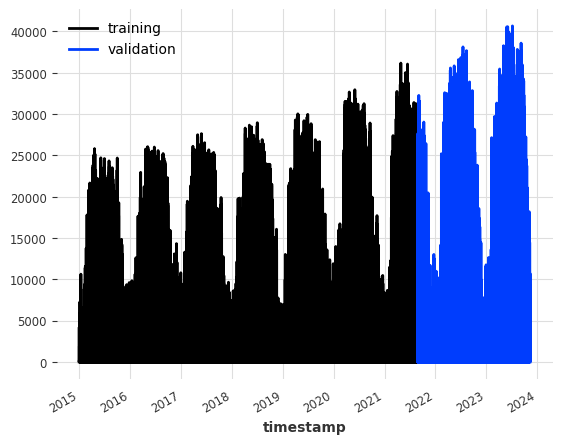

In [ ]:
# Get the first 75% of the series as training data and the rest as validation data
split_index = int(len(series) * 0.75)
split_date = series.time_index[split_index]

# Create Train-Validation split
CUTOFF_DATE = split_date

train, val = series.split_before(pd.Timestamp(CUTOFF_DATE))
train.plot(label="training")
val.plot(label="validation")

In [ ]:
# We want to predict the length of the validation set into the future
PREDICTION_LENGTH = len(val)

/Users/raphael/miniforge3/envs/aip-porsche/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<Axes: xlabel='timestamp'>

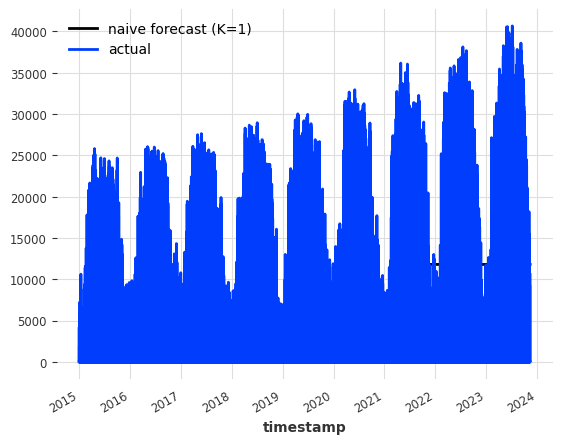

In [ ]:
# Create a very naive model, which just repeats last value of the training set

from darts.models import NaiveSeasonal

naive_model = NaiveSeasonal(K=1)
naive_model.fit(train)
naive_forecast = naive_model.predict(PREDICTION_LENGTH)

naive_forecast.plot(label="naive forecast (K=1)")
series.plot(label="actual")

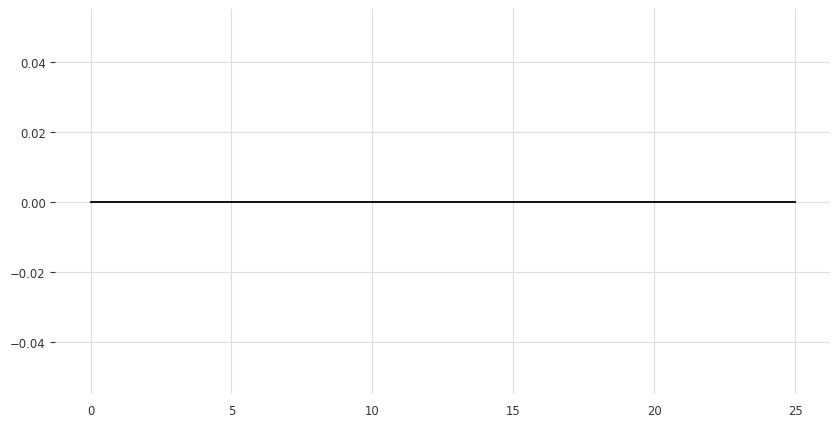

In [ ]:
from darts.utils.statistics import plot_acf, check_seasonality

plot_acf(train, m=11, alpha=0.05)

In [ ]:
for m in range(2, 25):
    is_seasonal, period = check_seasonality(train, m=m, alpha=0.5)
    if is_seasonal:
        print("There is seasonality of order {}.".format(period))

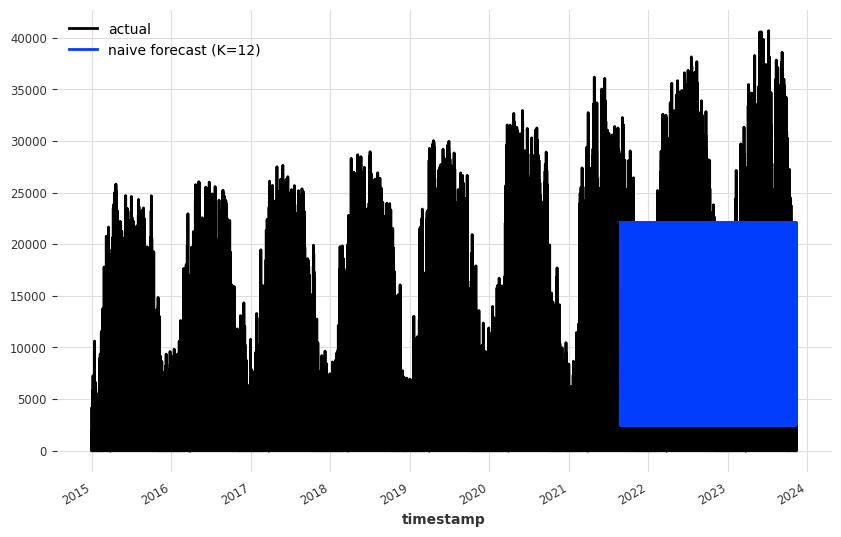

In [ ]:
import matplotlib.pyplot as plt

seasonal_model = NaiveSeasonal(K=11)
seasonal_model.fit(train)
seasonal_forecast = seasonal_model.predict(PREDICTION_LENGTH)

plt.figure(figsize=(10,6))
series.plot(label="actual")
seasonal_forecast.plot(label="naive forecast (K=12)")

#plt.xlim(pd.Timestamp('2018-05-18'), pd.Timestamp('2018-06-23'))
plt.show()

<Axes: xlabel='timestamp'>

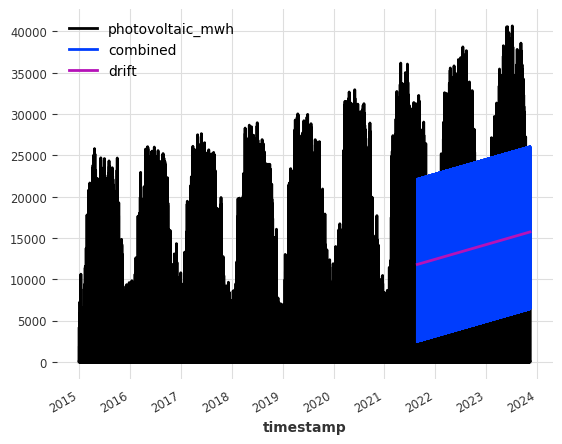

In [ ]:
from darts.models import NaiveDrift

drift_model = NaiveDrift()
drift_model.fit(train)
drift_forecast = drift_model.predict(PREDICTION_LENGTH)

combined_forecast = drift_forecast + seasonal_forecast - train.last_value()

series.plot()
combined_forecast.plot(label="combined")
drift_forecast.plot(label="drift")

In [ ]:
from darts.metrics import mape

print(
    "Mean absolute percentage error for the combined naive drift + seasonal: {:.2f}%.".format(
        mape(series, combined_forecast)
    )
)

ValueError: The actual series must be strictly positive to compute the MAPE.


ValueError: The actual series must be strictly positive to compute the MAPE.

In [ ]:
from darts.models import ExponentialSmoothing, TBATS, AutoARIMA, Theta

In [ ]:
def eval_model(model):
    model.fit(train)
    forecast = model.predict(len(val))
    print("model {} obtains MAPE: {:.2f}%".format(model, mape(val, seasonal_forecast)))


eval_model(ExponentialSmoothing())
eval_model(TBATS())
eval_model(AutoARIMA())
eval_model(Theta())

model ExponentialSmoothing() obtains MAPE: 1.80%
model TBATS() obtains MAPE: 1.80%
model AutoARIMA() obtains MAPE: 1.80%
model Theta() obtains MAPE: 1.80%


In [ ]:
# Search for the best theta parameter, by trying 50 different values
thetas = 2 - np.linspace(-10, 10, 50)

best_mape = float("inf")
best_theta = 0

for theta in thetas:
    model = Theta(theta)
    model.fit(train)
    pred_theta = model.predict(len(val))
    res = mape(val, pred_theta)

    if res < best_mape:
        best_mape = res
        best_theta = theta

In [ ]:
best_theta_model = Theta(best_theta)
best_theta_model.fit(train)
pred_best_theta = best_theta_model.predict(len(val))

print(
    "The MAPE is: {:.2f}, with theta = {}.".format(
        mape(val, pred_best_theta), best_theta
    )
)

The MAPE is: 1.39, with theta = 0.16326530612244916.


<Axes: xlabel='timestamp'>

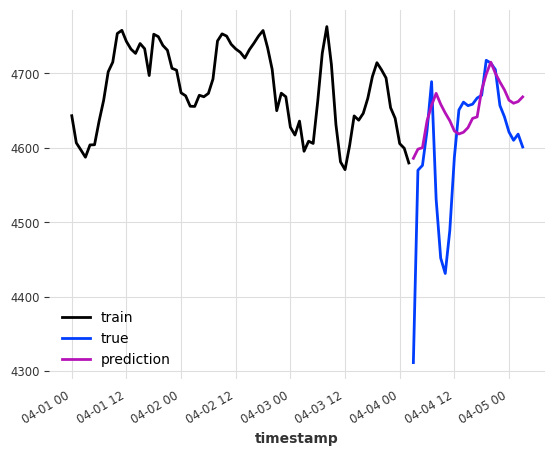

In [ ]:
train.plot(label="train")
val.plot(label="true")
pred_best_theta.plot(label="prediction")

<Axes: xlabel='timestamp'>

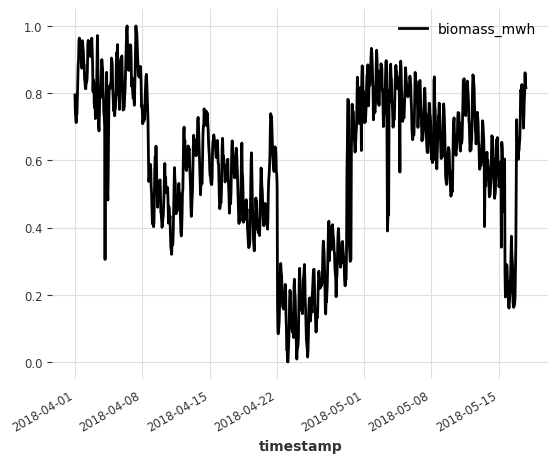

In [ ]:
from darts.dataprocessing.transformers import Scaler

scaler = Scaler()
train_scaled = scaler.fit_transform(train)

train_scaled.plot()

In [ ]:
from darts.models import NBEATSModel

model = NBEATSModel(input_chunk_length=24, output_chunk_length=12, random_state=42)

model.fit(train_scaled, epochs=15, verbose=True);

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 6.2 M 
---------------------------------------------------
6.2 M     Trainable params
1.4 K     Non-trainable params
6.2 M     Total params
24.787    Total estimated model params size (MB)


Epoch 14: 100%|██████████| 35/35 [00:08<00:00,  4.02it/s, train_loss=0.00566]

`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: 100%|██████████| 35/35 [00:08<00:00,  4.02it/s, train_loss=0.00566]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  1.28it/s]


<Axes: xlabel='timestamp'>

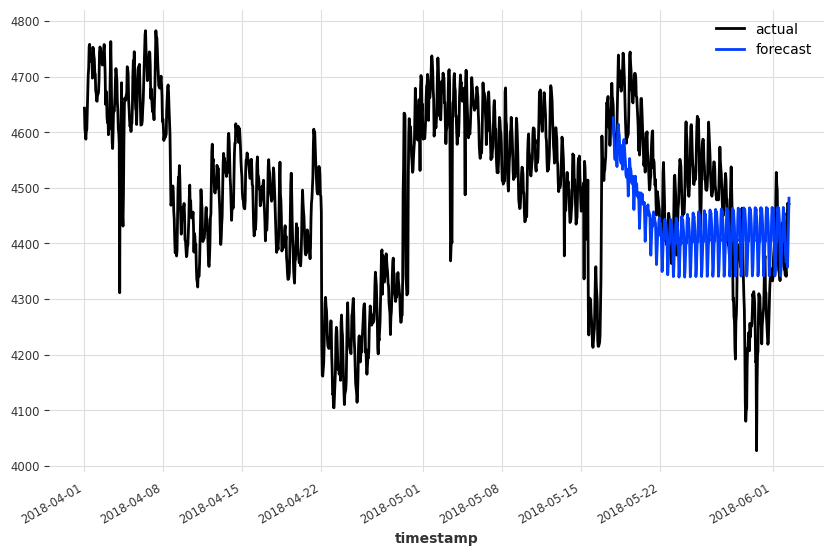

In [ ]:
pred = model.predict(series=train_scaled, n=PREDICTION_LENGTH)

pred = scaler.inverse_transform(pred)

plt.figure(figsize=(10, 6))
series.plot(label="actual")
pred.plot(label="forecast")

In [ ]:
mape(val, pred)

2.4175966158509254